# Function 1

## Description
Detect likely contamination sources in a two-dimensional area, such as a radiation field, where only proximity yields a 
non-zero reading. The system uses Bayesian optimisation to tune detection parameters and reliably identify both strong 
and weak sources.

## Libraries

In [14]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

## Data

In [10]:
# --- Step 1: Define the initial data ---
df_init = pd.DataFrame({
    "x1": [0.319403889, 0.574329215, 0.731023631, 0.840353417, 0.65011406,
           0.410437137, 0.312691157, 0.683418169, 0.082507252, 0.883889829],
    "x2": [0.762959374, 0.879898105, 0.732999876, 0.264731614, 0.681526352,
           0.147554299, 0.078722778, 0.861057464, 0.403487506, 0.582253974],
    "y":  [1.32268e-79, 1.03e-46, 7.71088e-16, 3.3418e-124, -3.606063e-03,
           -2.15925e-54, -2.08909e-91, 2.535e-40, 3.60677e-81, 6.22986e-48]
})

# --- Step 2: Weekly added data ---
new_data = [
    (0.758389, 0.758389, 1.58615162914556E-24),  # week 1
    (0.718121, 0.000000, -8.15298908061967E-186),  # week 2
    (0.738255, 0.442953, -1.33849366190357E-33),  # week 3
    (0.758389, 0.684564, -7.29229745163929E-15),  # week 4
    (1.000000, 0.731544, 4.12013348895405E-104),  # week 5
    (0.644295, 0.738255, -1.49308886506925E-09),  # week 6
    (0.697987, 0.785235, -7.22535432596961E-21),  # week 7
    (0.402685, 0.496644, -0.0000486646003352533),  # week 8
    (0.536913, 0.315436, 3.61113044121337E-19),  # week 9
    (0.503356, 0.322148, 2.04631909007374E-12),  # week 10
    (0.496644, 0.308725, 3.4788896110438E-14),  # week 11
    (0.476510, 0.322148, 4.37004415691818E-10),  # week 12
    (0.469799, 0.335570, 6.04205550580491E-08),  # week 13
]
df_new = pd.DataFrame(new_data, columns=["x1", "x2", "y"])
df_all = pd.concat([df_init, df_new], ignore_index=True)

# --- Step 3: Convert to NumPy arrays for modelling ---
X_check = df_all[["x1", "x2"]].values  # shape (10, 2)
y_check = df_all["y"].values.reshape(-1, 1)  # shape (10, 1)

# --- Step 4: Quick verification ---
print("Dataset shape:", X_check.shape, y_check.shape)
print(df_all)

Dataset shape: (23, 2) (23, 1)
          x1        x2              y
0   0.319404  0.762959   1.322680e-79
1   0.574329  0.879898   1.030000e-46
2   0.731024  0.733000   7.710880e-16
3   0.840353  0.264732  3.341800e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159250e-54
6   0.312691  0.078723  -2.089090e-91
7   0.683418  0.861057   2.535000e-40
8   0.082507  0.403488   3.606770e-81
9   0.883890  0.582254   6.229860e-48
10  0.758389  0.758389   1.586152e-24
11  0.718121  0.000000 -8.152989e-186
12  0.738255  0.442953  -1.338494e-33
13  0.758389  0.684564  -7.292297e-15
14  1.000000  0.731544  4.120133e-104
15  0.644295  0.738255  -1.493089e-09
16  0.697987  0.785235  -7.225354e-21
17  0.402685  0.496644  -4.866460e-05
18  0.536913  0.315436   3.611130e-19
19  0.503356  0.322148   2.046319e-12
20  0.496644  0.308725   3.478890e-14
21  0.476510  0.322148   4.370044e-10
22  0.469799  0.335570   6.042056e-08


## Optimisation Model

In [11]:
# ---- 1) Initialize
X_init = df_all[["x1", "x2"]].to_numpy()
y_raw = df_all["y"].to_numpy()

# --- Adjustable parameters ---
EPS = 1e-40
nu = 1.5
grid_n = 150  # keep modest for speed; increase to 100 for finer suggestion
beta = 1.5  # larger => more exploration
random_state = 0

# ---- 2) Prep target: stable log scale for tiny values ----
# Floor to a tiny positive so log() is defined; negative or ~0 become a small floor (treated as "very low").

y_log = np.log(np.maximum(y_raw, 0.0) + EPS)  # shape (N,)

# ---- 3) Fit a simple GP surrogate ----
# Matérn with ARD-like behavior (length_scale per-dim) + small noise term.
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.1,0.1], nu=nu) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 1e-2))

gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3, random_state=random_state)
gp.fit(X_init, y_log)

# ---- 4) Build a candidate grid over [0,1]^2 ----
xs = np.linspace(0.0, 1.0, grid_n)
X1, X2 = np.meshgrid(xs, xs)
X_cand = np.column_stack([X1.ravel(), X2.ravel()])  # (grid_n^2, 2)

# ---- 5) Predict mean & std in log-space; compute UCB ----
mu_log, std_log = gp.predict(X_cand, return_std=True)
ucb = mu_log + beta * std_log

# ---- 6) Pick next point (argmax UCB) ----
best_idx = int(np.argmax(ucb))
x_next = X_cand[best_idx]
# x_next = X_cand[np.argmax(std_log)]

# ---- 7) Print suggestion + a few top candidates ----
top_k = 5
top_idx = np.argsort(-ucb)[:top_k]
print("Next suggested point (UCB): (x1, x2) =", tuple(np.round(x_next, 6)))
print("\nTop candidates:")
for rank, i in enumerate(top_idx, 1):
    print(f"{rank:>2}. (x1={X_cand[i,0]:.6f}, x2={X_cand[i,1]:.6f})  UCB={ucb[i]:.6f}  mu_log={mu_log[i]:.6f}  std_log={std_log[i]:.6f}")

# ---- 8) the *original-scale* expected value estimate at x_next ----
mu_log_next, std_log_next = gp.predict(x_next.reshape(1, -1), return_std=True)
mu_est_original = np.exp(mu_log_next)  # back-transform (approx)
print("Back-transformed expected value (approx):", float(mu_est_original))
print("")

### optional distance penalising functions ###
dmin = cdist(X_cand, X_init).min(axis=1)   # distance to nearest sampled point
alpha = 1.0  # tune 0.2–1.0; higher => more exploratory
acq_explore = ucb + alpha * dmin
x_next = X_cand[np.argmax(acq_explore)]
print("Optional 1: Next (UCB + distance bonus):", x_next)

### optional exclusion radius ###
r = 0.15  # exclusion radius (try 0.12–0.15)
dmin = cdist(X_cand, X_init).min(axis=1)
mask = dmin >= r
x_next = X_cand[mask][np.argmax(ucb[mask])]
print("Optional 2: Next (UCB with exclusion radius):", x_next)

### optional force box exploration ###
box_mask = (
    (X_cand[:, 0] >= 0.2) & (X_cand[:, 0] <= 0.6) &
    (X_cand[:, 1] >= 0.2) & (X_cand[:, 1] <= 0.4)
)
x_next = X_cand[box_mask][np.argmax(ucb[box_mask])]
print("Optional 3: Next (forced box UCB):", x_next)

Next suggested point (UCB): (x1, x2) = (0.436242, 0.33557)

Top candidates:
 1. (x1=0.436242, x2=0.335570)  UCB=-8.181587  mu_log=-24.510420  std_log=10.885888
 2. (x1=0.429530, x2=0.335570)  UCB=-8.294480  mu_log=-27.104357  std_log=12.539918
 3. (x1=0.436242, x2=0.342282)  UCB=-8.396803  mu_log=-25.728154  std_log=11.554234
 4. (x1=0.442953, x2=0.335570)  UCB=-8.522425  mu_log=-22.097728  std_log=9.050202
 5. (x1=0.429530, x2=0.342282)  UCB=-8.579679  mu_log=-28.202448  std_log=13.081846
Back-transformed expected value (approx): 2.26600041397624e-11

Optional 1: Next (UCB + distance bonus): [0.43624161 0.33557047]
Optional 2: Next (UCB with exclusion radius): [0.31543624 0.32885906]
Optional 3: Next (forced box UCB): [0.43624161 0.33557047]


## Visualisation
### Part 1: Acquisition function chart (UCB) + mean/std context

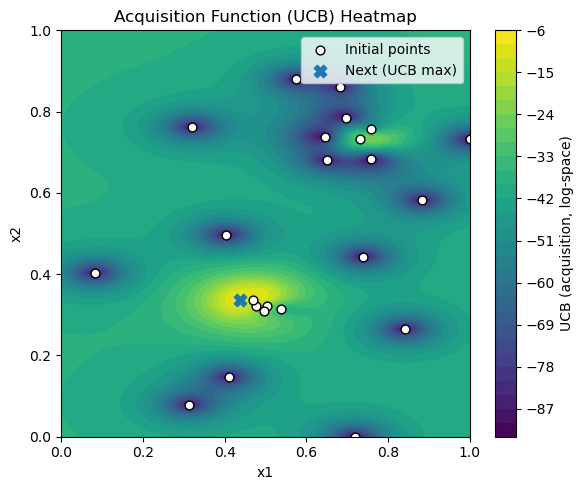

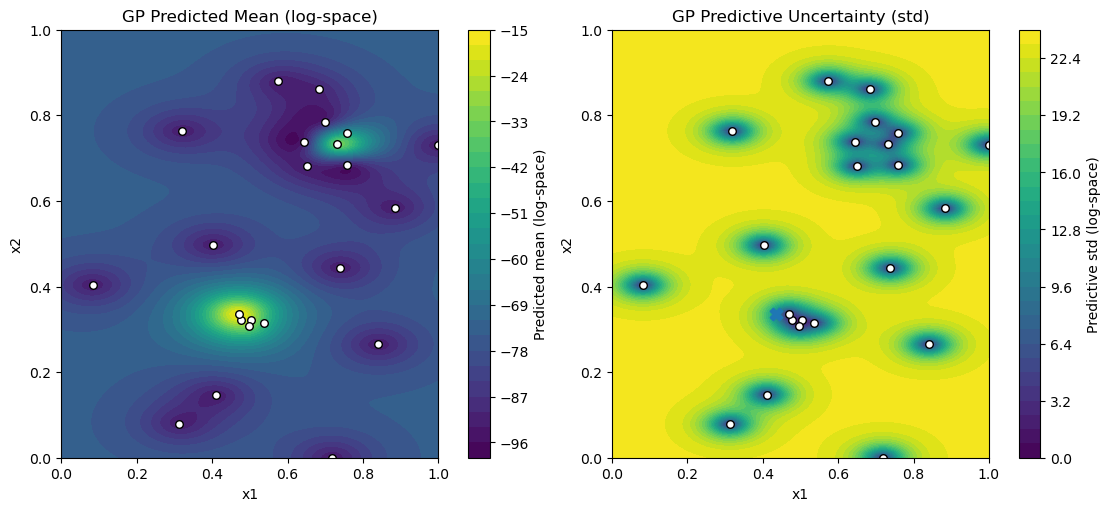

In [12]:
# Uses existing variables: X1, X2, grid_n, mu_log, std_log, ucb, X_init, x_next
UCB_grid = ucb.reshape(grid_n, grid_n)
MU_grid  = mu_log.reshape(grid_n, grid_n)
STD_grid = std_log.reshape(grid_n, grid_n)

# (A) Pure acquisition function heatmap (UCB)
plt.figure(figsize=(6,5))
cs = plt.contourf(X1, X2, UCB_grid, levels=30)
plt.colorbar(cs, label="UCB (acquisition, log-space)")
plt.scatter(X_init[:,0], X_init[:,1], s=40, edgecolor='k', facecolor='white', label='Initial points')
plt.scatter([x_next[0]], [x_next[1]], s=80, marker='X', label='Next (UCB max)')
plt.title("Acquisition Function (UCB) Heatmap")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# (B) Side-by-side mean vs uncertainty to see exploration/exploitation drivers
fig, axes = plt.subplots(1, 2, figsize=(11,5), constrained_layout=True)

m0 = axes[0].contourf(X1, X2, MU_grid, levels=30)
plt.colorbar(m0, ax=axes[0], label="Predicted mean (log-space)")
axes[0].scatter(X_init[:,0], X_init[:,1], s=30, edgecolor='k', facecolor='white')
axes[0].set_title("GP Predicted Mean (log-space)")
axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2")

m1 = axes[1].contourf(X1, X2, STD_grid, levels=30)
plt.colorbar(m1, ax=axes[1], label="Predictive std (log-space)")
axes[1].scatter(X_init[:,0], X_init[:,1], s=30, edgecolor='k', facecolor='white')
axes[1].scatter([x_next[0]], [x_next[1]], s=80, marker='X')
axes[1].set_title("GP Predictive Uncertainty (std)")
axes[1].set_xlabel("x1"); axes[1].set_ylabel("x2")

plt.show()

### Part 2: 3D surface plot of the acquisition function (UCB)

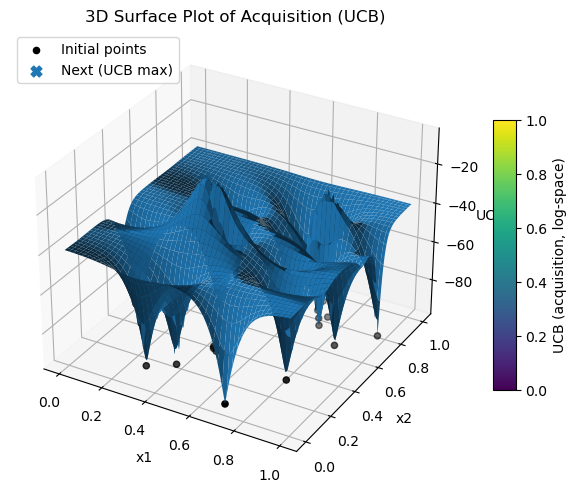

In [13]:
# "3D surface plot" for a slope-like view of the acquisition landscape.

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

# Downsample a bit for speed if needed:
ds = 1  # increase to 2 or 3 if your grid is very fine
X_plot = X1[::ds, ::ds]
Y_plot = X2[::ds, ::ds]
Z_plot = UCB_grid[::ds, ::ds]

surf = ax.plot_surface(X_plot, Y_plot, Z_plot, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.6, aspect=12, label="UCB (acquisition, log-space)")

# Mark initial points and next point on the surface (projected slightly above)
ax.scatter(X_init[:,0], X_init[:,1], np.interp(
    X_init[:,0] + 0*X_init[:,1], X_plot.ravel(), Z_plot.ravel(), left=np.nan, right=np.nan
)*0 + Z_plot.min(), s=20, c='k', label='Initial points')  # projected near base
ax.scatter([x_next[0]], [x_next[1]], [Z_plot.max()], s=60, marker='X', label='Next (UCB max)')

ax.set_title("3D Surface Plot of Acquisition (UCB)")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("UCB")
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()